# **Building Binary Classification Model to Predict Customer Churns**

# Description of Dataset:
Dataset used in this exercised are housed @ **theforage.com** under the **BCG Data Analytics** Virtual Internship program Task 3 [1]. This exercise used 2 spreadsheets: **'client_data.csv'** and **'price_data.csv'**.



# Contents

---

1. Import packages
2. Load and pre-process data
3. Feature engineering
4. Model building
5. Performance metrics 
6. Explore strategies for imbalanced datasets

---

## 1. Import packages

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load and Pre-process data

In [ ]:
# load client dataset
df = pd.read_csv('./client_data.csv')#./clean_client_df.csv')#'./clean_data_after_eda.csv') #

# cast datetime objects
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [ ]:
df.info()
df.head(3).T
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

(14606, 26)

In [ ]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.info()
price_df.sample(3).T

# pricing data is a collection of pricing charged to different clients (id) dated on first of every months.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


,155277,109000,87272
id,a2b56155b068764870f5beea31fa43d3,bfc91735bb7c01579910302ed6bf3f45,c441975761e1e061e913183bf7bbb417
price_date,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-08-01 00:00:00
price_off_peak_var,0.151367,0.150211,0.1476
price_peak_var,0.0,0.0,0.0
price_mid_peak_var,0.0,0.0,0.0
price_off_peak_fix,44.266931,44.266931,44.44471
price_peak_fix,0.0,0.0,0.0
price_mid_peak_fix,0.0,0.0,0.0


---

## 3. Feature engineering
### 3.1. Price Dataset

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [ ]:
price_df.columns

Index(['id', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix'],
      dtype='object')

In [ ]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_p1 = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff_p1['offpeak_diff_dec_jan_energy'] = diff_p1['dec_1'] - diff_p1['price_off_peak_var']
diff_p1['offpeak_diff_dec_jan_power'] = diff_p1['dec_2'] - diff_p1['price_off_peak_fix']
diff_p1 = diff_p1[['id', 'offpeak_diff_dec_jan_energy','offpeak_diff_dec_jan_power']]
diff_p1.head()

,id,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [ ]:
# Group off-peak prices by id and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_var': 'mean', 'price_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_p2_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_p2_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_p2 = pd.merge(dec_p2_prices.rename(columns={'price_peak_var': 'dec_1', 'price_peak_fix': 'dec_2'}), jan_p2_prices.drop(columns='price_date'), on='id')
diff_p2['peak_diff_dec_jan_energy'] = diff_p2['dec_1'] - diff_p2['price_peak_var']
diff_p2['peak_diff_dec_jan_power'] = diff_p2['dec_2'] - diff_p2['price_peak_fix']
diff_p2 = diff_p2[['id', 'peak_diff_dec_jan_energy','peak_diff_dec_jan_power']]
diff_p2.head(3)

,id,peak_diff_dec_jan_energy,peak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,-0.002302,0.097749
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000


In [ ]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_mid_peak_var': 'mean', 'price_mid_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_p3_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_p3_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff_p3 = pd.merge(dec_p3_prices.rename(columns={'price_mid_peak_var': 'dec_1', 'price_mid_peak_fix': 'dec_2'}), jan_p3_prices.drop(columns='price_date'), on='id')
diff_p3['midpeak_diff_dec_jan_energy'] = diff_p3['dec_1'] - diff_p3['price_mid_peak_var']
diff_p3['midpeak_diff_dec_jan_power'] = diff_p3['dec_2'] - diff_p3['price_mid_peak_fix']
diff_p3 = diff_p3[['id', 'midpeak_diff_dec_jan_energy','midpeak_diff_dec_jan_power']]
diff_p3.head(3)

,id,midpeak_diff_dec_jan_energy,midpeak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000


In [ ]:
dec_jan_price_diff = pd.merge(diff_p1,diff_p2, on='id')
dec_jan_price_diff.head()

,id,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power,peak_diff_dec_jan_energy,peak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.097749
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.005120,0.097749
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0.000000,0.000000


In [ ]:
dec_jan_price_diff = pd.merge(dec_jan_price_diff, diff_p3, on='id')
dec_jan_price_diff.head()

,id,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power,peak_diff_dec_jan_energy,peak_diff_dec_jan_power,midpeak_diff_dec_jan_energy,midpeak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.005120,0.097749,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0.000000,0.000000,0.000000,0.000000


## 3.2. Client Dataset

### Add features to client dataset for training

### 3.2.1. Calculate date differences

In [ ]:
client_df = df.copy()  
client_df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')

In [ ]:
from datetime import date

# calculate date difference (in #days) between (1) date_end to date_activ, (2) date_end to date_renew
client_df['activ2end'] = (client_df.date_end - client_df.date_activ).dt.days
client_df['renew2end'] = (client_df.date_end - client_df.date_renewal).dt.days
client_df['modif2activ'] = (client_df.date_modif_prod - client_df.date_activ).dt.days
client_df['modif2end'] = (client_df.date_modif_prod - client_df.date_end).dt.days#.abs()
client_df['modif2renew'] = (client_df.date_modif_prod - client_df.date_renewal).dt.days#.abs()

# inspect new features
client_df[['date_activ','date_end','date_renewal','date_modif_prod','activ2end',
           'renew2end','modif2activ','modif2end','modif2renew','churn']].sample(5)

,date_activ,date_end,date_renewal,date_modif_prod,activ2end,renew2end,modif2activ,modif2end,modif2renew,churn
6136,2012-05-03,2016-05-03,2015-05-04,2012-05-03,1461,365,0,-1461,-1096,0
14023,2009-11-05,2016-11-04,2015-11-05,2015-09-20,2556,365,2145,-411,-46,1
8363,2012-06-08,2016-06-08,2015-06-22,2013-11-05,1461,352,515,-946,-594,0
8575,2011-11-21,2016-11-21,2015-11-22,2011-11-21,1827,365,0,-1827,-1462,0
5953,2012-06-20,2016-06-20,2015-06-23,2012-06-20,1461,363,0,-1461,-1098,0


### 3.2.2. Map string into integer representation then cast categorical data and onehot encode

In [ ]:
cat1 = list(client_df.origin_up.unique())
print(cat1)
a = [i for i in cat1 if i != 'MISSING']
cat = ['MISSING'] + a
dict ={k:v for v,k in enumerate(cat)}
client_df.origin_up = client_df.origin_up.map(dict)
client_df.origin_up.value_counts()
# category 0, 4, and 5 are negligible --> to drop after onehot encode

['lxidpiddsbxsbosboudacockeimpuepw', 'kamkkxfxxuwbdslkwifmmcsiusiuosws', 'ldkssxwpmemidmecebumciepifcamkci', 'MISSING', 'usapbepcfoloekilkwsdiboslwaxobdp', 'ewxeelcelemmiwuafmddpobolfuxioce']


1    7097
2    4294
3    3148
0      64
4       2
5       1
Name: origin_up, dtype: int64

In [ ]:
cat1 = list(client_df.channel_sales.unique())
a = [i for i in cat1 if i != 'MISSING']
cat = ['MISSING'] + a
dict ={k:v for v,k in enumerate(cat)}
client_df.channel_sales = client_df.channel_sales.map(dict)
client_df.channel_sales.value_counts()
# category 6,7, and 5 are negligible --> to drop after onehot encode

1    6754
0    3725
2    1843
3    1375
4     893
6      11
5       3
7       2
Name: channel_sales, dtype: int64

In [ ]:
client_df.has_gas = client_df.has_gas.map({'f':0,'t':1})
client_df.has_gas.value_counts()

0    11955
1     2651
Name: has_gas, dtype: int64

In [ ]:
# cast numeric representation of string datatype to categorical type
client_df[['origin_up','has_gas','channel_sales']].astype('category')

,origin_up,has_gas,channel_sales
0,1,1,1
1,2,0,0
2,2,0,1
3,2,0,2
4,2,0,0
...,...,...,...
14601,1,1,1
14602,1,0,1
14603,1,0,1
14604,1,0,1


In [ ]:
# onehot encode origin_up and drop encoded columns category 0, 4, 5 (negligible counts)
client_df = pd.get_dummies(client_df, columns=['origin_up'], prefix='origin_up')
client_df = client_df.drop(columns=['origin_up_4','origin_up_5','origin_up_0'], axis=1)
client_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,pow_max,churn,activ2end,renew2end,modif2activ,modif2end,modif2renew,origin_up_1,origin_up_2,origin_up_3
0,24011ae4ebbe3035111d65fa7c15bc57,1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,43.648,1,1096,358,869,-227,131,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,13.800,0,2566,365,0,-2566,-2201,0,1,0
2,764c75f661154dac3a6c254cd082ea7d,1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,13.856,0,2192,365,0,-2192,-1827,0,1,0
3,bba03439a292a1e166f80264c16191cb,2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,13.200,0,2192,365,0,-2192,-1827,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,0,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,19.800,0,2245,364,0,-2245,-1881,0,1,0


In [ ]:
# onehot encode has_gas
client_df = pd.get_dummies(client_df, columns=['has_gas'], prefix='has_gas')

In [ ]:
# onehot encode channel_sales, drop encoded column for category 6,7,5 (negligible counts)
client_df = pd.get_dummies(client_df, columns=['channel_sales'], prefix='channel_sales')
client_df = client_df.drop(columns=['channel_sales_6','channel_sales_7','channel_sales_5'], axis=1)
client_df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,origin_up_1,origin_up_2,origin_up_3,has_gas_0,has_gas_1,channel_sales_0,channel_sales_1,channel_sales_2,channel_sales_3,channel_sales_4
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,1,0,0,0,1,0,1,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,0,1,0,1,0,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,0,1,0,1,0,0,1,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,0,1,0,1,0,0,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,0,1,0,1,0,1,0,0,0,0


### 3.2.3. Merge diff_price and client_df based on matching ids

In [ ]:
# check and compare price_id and client_id
a = list(dec_jan_price_diff.id.unique())
b = list(client_df.id.unique())
print(len(a), len(b))
print(len([i for i in a if i in b]))
      # all price_id's are in client_id's

16096 14606
14606


In [ ]:
df = pd.merge(client_df, dec_jan_price_diff, on='id').reset_index() 
                    # without reset_index, id becomes row index
df.head().T

,0,1,2,3,4
index,0,1,2,3,4
id,24011ae4ebbe3035111d65fa7c15bc57,d29c2c54acc38ff3c0614d0a653813dd,764c75f661154dac3a6c254cd082ea7d,bba03439a292a1e166f80264c16191cb,149d57cf92fc41cf94415803a877cb4b
cons_12m,0,4660,544,1584,4425
cons_gas_12m,54946,0,0,0,0
cons_last_month,0,0,0,0,526
date_activ,2013-06-15 00:00:00,2009-08-21 00:00:00,2010-04-16 00:00:00,2010-03-30 00:00:00,2010-01-13 00:00:00
date_end,2016-06-15 00:00:00,2016-08-30 00:00:00,2016-04-16 00:00:00,2016-03-30 00:00:00,2016-03-07 00:00:00
date_modif_prod,2015-11-01 00:00:00,2009-08-21 00:00:00,2010-04-16 00:00:00,2010-03-30 00:00:00,2010-01-13 00:00:00
date_renewal,2015-06-23 00:00:00,2015-08-31 00:00:00,2015-04-17 00:00:00,2015-03-31 00:00:00,2015-03-09 00:00:00
forecast_cons_12m,0.0,189.95,47.96,240.04,445.75


In [ ]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    
    # 'forecast_price_energy_p1',
    # 'forecast_price_energy_p2', 
    # 'forecast_price_pow_p1',
    
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

In [ ]:
# Suggestion from model solution: to transform highly skewed feature columns using log transform to reduce standard deviation
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [ ]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [ ]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


In [ ]:
newcol = ['churn'] + [cols for cols in df.columns if cols != 'churn']
df = df[newcol]
print(len(df.columns), df.columns[0])

45 churn


In [ ]:
df.shape

(14606, 45)

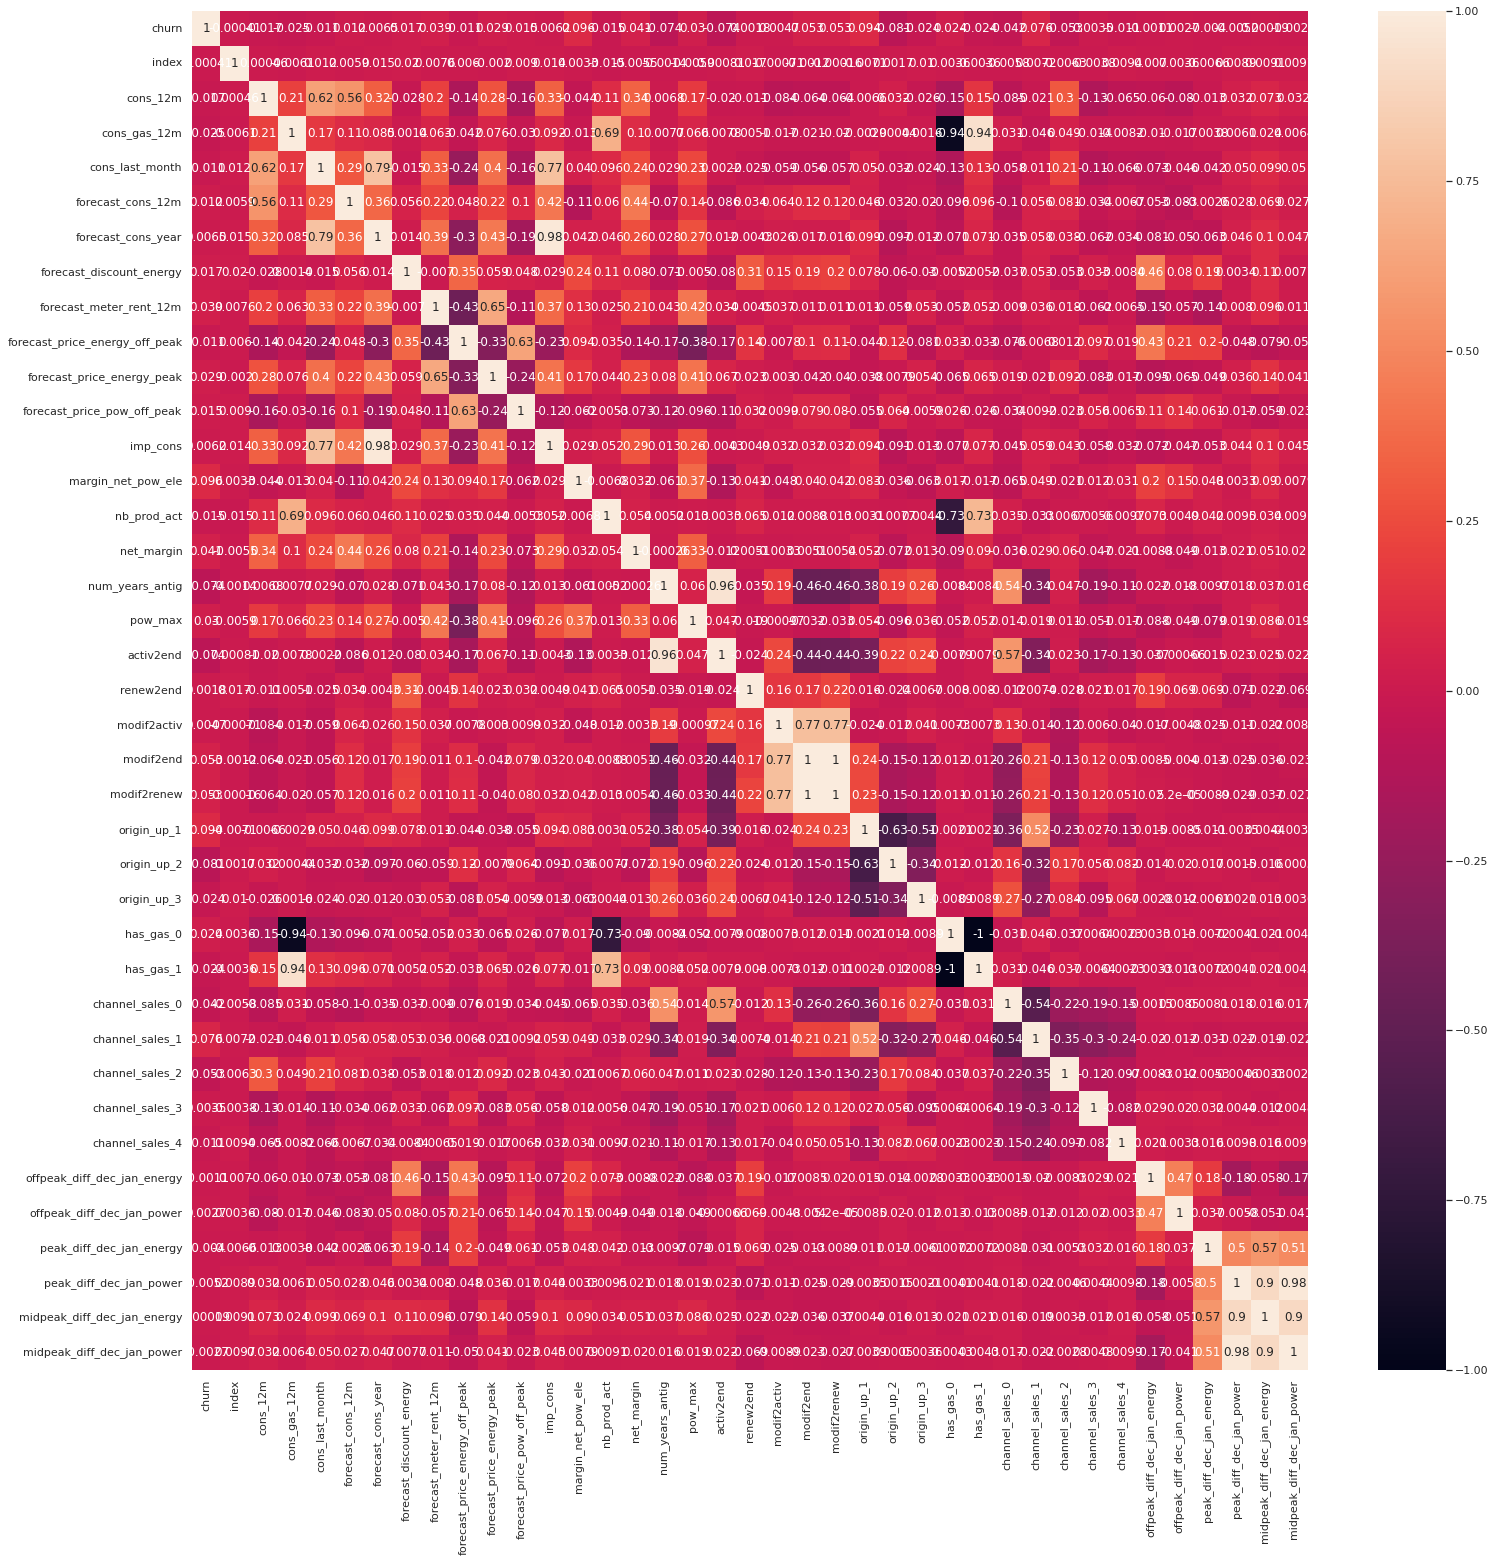

In [ ]:
# prepare feature matrix and check correlations of predictors
X = df.drop(columns=['date_activ', 'date_end', 'date_modif_prod','date_renewal','margin_gross_pow_ele','id']) 
                                                  # 'margin_gross_pow_ele' identical to 'margin_net_pow_ele' cols except for 2 rows
# check correlation profiles of each predictors
corr_matrix = X.corr()

plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

y = X.churn
X = X.drop('churn', axis=1)

### no particular feature(s) showing strong predictive power for churning.

# 4. Train Binary Classification Models

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
X = minmax_scale(X)
ranstate = 4321
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=ranstate)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 38)
(10954,)
(3652, 38)
(3652,)


In [ ]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=ranstate), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=ranstate),
               RandomForestClassifier(random_state=ranstate)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers','fpr','tpr','auc','prec','recl','aps','ypred','yproba'])

# Train the models and store the results into df
for clf in classifiers:
    model = clf.fit(X_train, y_train)
    
    # calc prediction and probability of predicting labels
    ypred = model.predict(X_test)
    yproba = model.predict_proba(X_test)[::,1]
    
    # calc fpr and tpr for roc_curve
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = round(roc_auc_score(y_test, yproba), 4)
    
    # calc precision and recall for PRcurve
    prec, recl, treshold = precision_recall_curve(y_test, yproba)
    aps = average_precision_score(y_test, ypred)
    
    result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'prec':prec,
                                        'recl':recl,
                                        'aps':aps,
                                        'ypred':ypred,
                                        'yproba':yproba}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 5. Calculate Metrics for Predictive Models

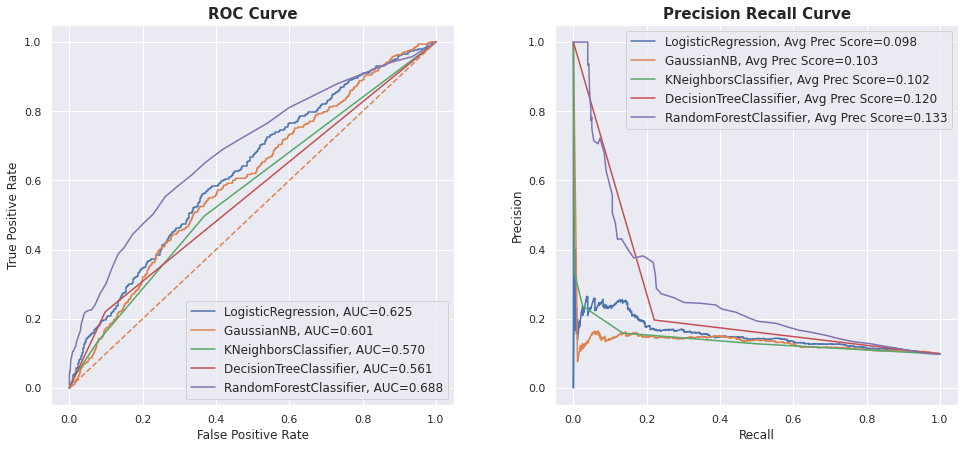

In [ ]:
# Plot figure and subplots
fig = plt.figure(figsize=[14,7])

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.45, wspace=0.05)   
ax1 = fig.add_subplot(gs1[0, 0])
for i in result_table.index:
    ax1.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
ax1.plot([0, 1], [0, 1], color = 'C1', linestyle='--')
ax1.set_title('ROC Curve', fontsize=15, fontweight='semibold')
ax1.set_xlabel('False Positive Rate', fontsize=12); ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_xlim([-0.05,1.05]); ax1.set_ylim([-0.05,1.05]); 
ax1.legend(prop={'size':12}, loc='lower right')

gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.55, right=0.95, wspace=0.05)
ax2 = fig.add_subplot(gs2[0, 0])
for i in result_table.index:
    ax2.plot(result_table.loc[i]['recl'], 
             result_table.loc[i]['prec'], 
             label="{}, Avg Prec Score={:.3f}".format(i, result_table.loc[i]['aps']))
ax2.set_title('Precision Recall Curve', fontsize=15, fontweight='semibold')
ax2.set_xlabel('Recall', fontsize=12); ax2.set_ylabel('Precision', fontsize=12)
ax2.set_xlim([-0.05,1.05]); ax2.set_ylim([-0.05,1.05])
ax2.legend(prop={'size':12}, loc='upper right')

plt.show()

In [ ]:
# define function to calculate classification metrics
def plot_clf_metrics(y_true, y_pred, y_proba, labels=['Neg Category','Pos Category']):
    
    # confusion matrix calc
    cm = confusion_matrix(y_true, y_pred)

    # ROC curve calc
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    # Precision Recall curve calc
    prec, recl, treshold = precision_recall_curve(y_true, y_proba)

    # Plot figure and subplots
    fig = plt.figure(figsize=[12,4])

    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.35, wspace=0.05)    
    ax1 = fig.add_subplot(gs1[0, 0])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax1)#, yticklabels=labels, xticklabels=labels)
    ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(labels, ha='center') 
    ax1.yaxis.set_ticklabels(labels, ha='center', rotation=90, rotation_mode='anchor')
    
    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, wspace=0.1)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.plot(fpr,tpr, color = 'b', label="AUC={:.3f}".format(roc_auc_score(y_true, y_proba)) )
    ax2.plot([0, 1], [0, 1], color = 'g', linestyle='--')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate'); ax2.set_ylabel('True Positive Rate')
    ax2.set_xlim([-0.05,1.05]); ax2.set_ylim([-0.05,1.05])
    ax2.legend(prop={'size':12}, loc='lower right')

    gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.8, right=1.05, wspace=0.15)
    ax3 = fig.add_subplot(gs3[0, 0])
    ax3.plot(recl,prec,  color = 'b', label="Avg Prec Score={:.3f}".format(average_precision_score(y_true, y_pred)) )
    ax3.set_title('Precision Recall Curve')
    ax3.set_xlabel('Recall'); ax3.set_ylabel('Precision')
    ax3.set_xlim([-0.05,1.05]); ax3.set_ylim([-0.05,1.05])
    ax3.legend(prop={'size':12}, loc='lower left')

    plt.show()

In [ ]:
# Retrain with balanced RF and XGBoost
rfb = RandomForestClassifier(class_weight='balanced', random_state=ranstate)
xgb = XGBClassifier(random_state=ranstate)

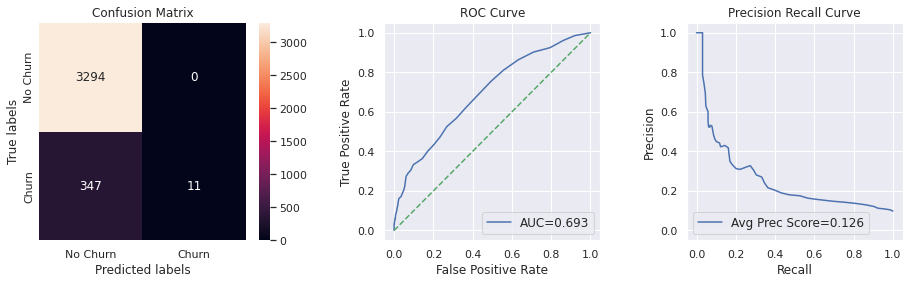

In [ ]:
rfb.fit(X_train,y_train)
y_predRFB = rfb.predict(X_test)
y_probaRFB = rfb.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predRFB, y_probaRFB[:,1], labels=['No Churn', 'Churn'])

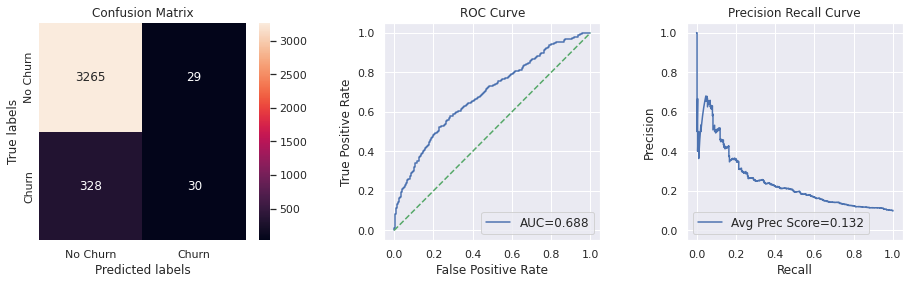

In [ ]:
xgb.fit(X_train,y_train)
y_predXGB = xgb.predict(X_test)
y_probaXGB = xgb.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predXGB, y_probaXGB[:,1], labels=['No Churn', 'Churn'])

# 6. Retrain RF and XGB Models with Undersampling/Oversampling Strategy for Imbalanced Datasets

## 6.1. Strategy 1: Upweight Minority Class 

Not all model accepts class_weight arg.

In [ ]:
# Calculate ratio of churn vs no churn in the dataset as the "upweight factor" estimate for the minority class

print(df.churn.value_counts())
upfactor = 13187/1419
weight = {0:1, 1:upfactor}

0    13187
1     1419
Name: churn, dtype: int64


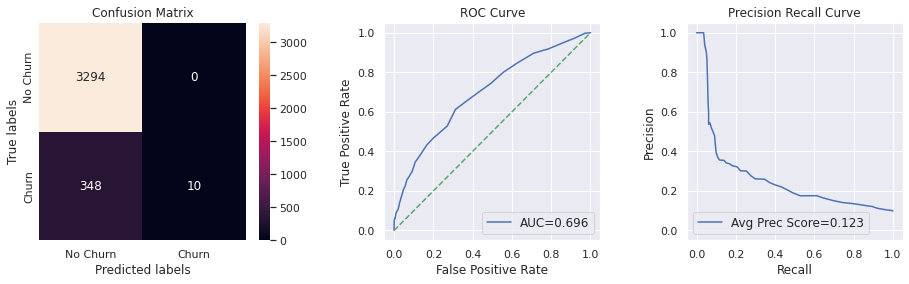

In [ ]:
# Retrain RFB 
rfb1 = RandomForestClassifier(class_weight=weight, random_state=ranstate)
rfb1.fit(X_train,y_train)
y_predRFB = rfb1.predict(X_test)
y_probaRFB = rfb1.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predRFB, y_probaRFB[:,1], labels=['No Churn', 'Churn'])


## 6.2. Oversampling minority class with SMOTE (Synthetic Minority Oversampling TEchnique)

Briefly, SMOTE class takes a subset of k_neighbor (default=5) datapoints in minority class and "interpolate" artificial samples from random pairs within these subset datapoints [2].

In [ ]:
from collections import Counter

Counter(y_train)

Counter({0: 9893, 1: 1061})

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=ranstate)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)
Counter(y_train_os)

Counter({0: 9893, 1: 9893})

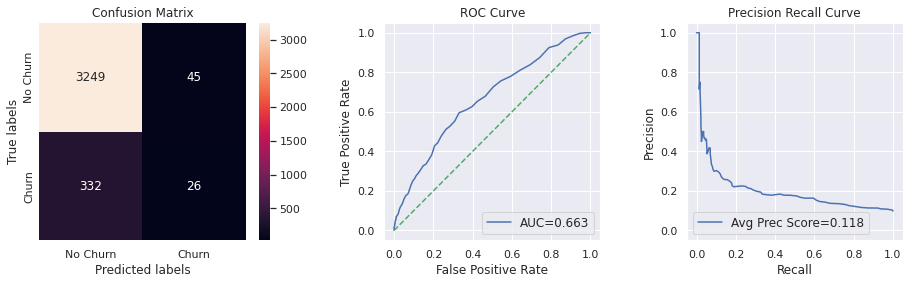

In [ ]:
# Retrain RFB 
rfb2 = RandomForestClassifier(class_weight=weight, random_state=ranstate)
rfb2.fit(X_train_os,y_train_os)
y_predRFB = rfb2.predict(X_test)
y_probaRFB = rfb2.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predRFB, y_probaRFB[:,1], labels=['No Churn', 'Churn'])


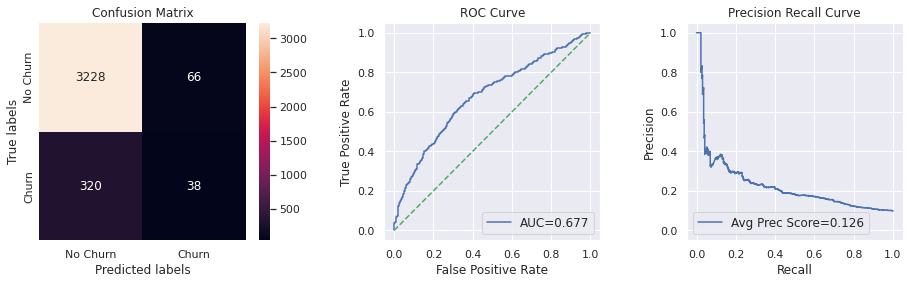

In [ ]:
# Retrain XGB
xgb2 = XGBClassifier(random_state=ranstate)
xgb2.fit(X_train_os,y_train_os)
y_predXGB = xgb2.predict(X_test)
y_probaXGB = xgb2.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predXGB, y_probaXGB[:,1], labels=['No Churn', 'Churn'])

## 6.3. Undersampling majority class randomly (applicable for large dataset)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

rus = RandomUnderSampler(random_state=ranstate)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Original training dataset: ', Counter(y_train))
print('Randomly Undersampled training dataset: ', Counter(y_train_rus))

Original training dataset:  Counter({0: 9893, 1: 1061})
Randomly Undersampled training dataset:  Counter({0: 1061, 1: 1061})


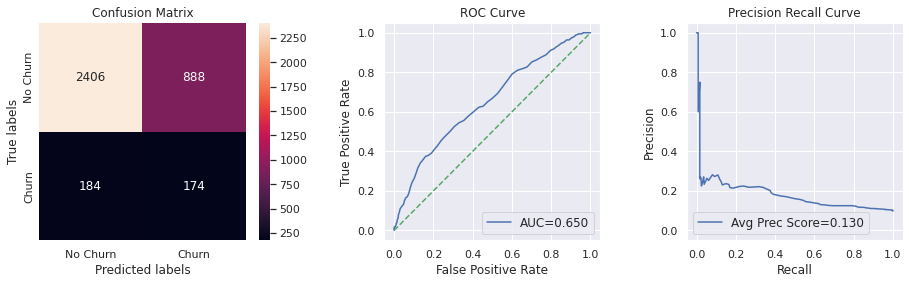

In [ ]:
# Retrain RFB 
rfb3 = RandomForestClassifier(class_weight=weight, random_state=ranstate)
rfb3.fit(X_train_rus,y_train_rus)
y_predRFB = rfb3.predict(X_test)
y_probaRFB = rfb3.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predRFB, y_probaRFB[:,1], labels=['No Churn', 'Churn'])


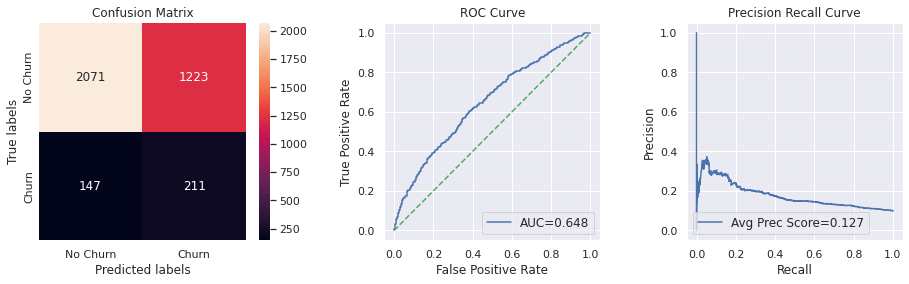

In [ ]:
# Retrain XGB
xgb3 = XGBClassifier(random_state=ranstate)
xgb3.fit(X_train_rus,y_train_rus)
y_predXGB = xgb3.predict(X_test)
y_probaXGB = xgb3.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predXGB, y_probaXGB[:,1], labels=['No Churn', 'Churn'])

## 6.4. Undersampling with NearMiss Algorithm

Instead of randomly undersampling, nearmiss algorithm applies some criteria to "exclude" datapoints from the majority class. There are 3 algorithms for nearmiss undersampling techniques [3]:
* NearMiss-1 selects the positive samples for which the average distance to the N closest samples of the negative class is the smallest.
* NearMiss-2 selects the positive samples for which the average distance to the N farthest samples of the negative class is the smallest.
* NearMiss-3 is a 2-steps algorithm. First, for each negative sample, their M
nearest-neighbors will be kept. Then, the positive samples selected are the one for which the average distance to the N nearest-neighbors is the largest.

In [ ]:
nmus = NearMiss(version=3)
X_train_nmus, y_train_nmus = nmus.fit_resample(X_train, y_train)
print('Original training dataset: ', Counter(y_train))
print('Undersampled training dataset: ', Counter(y_train_nmus))

Original training dataset:  Counter({0: 9893, 1: 1061})
Undersampled training dataset:  Counter({0: 1061, 1: 1061})


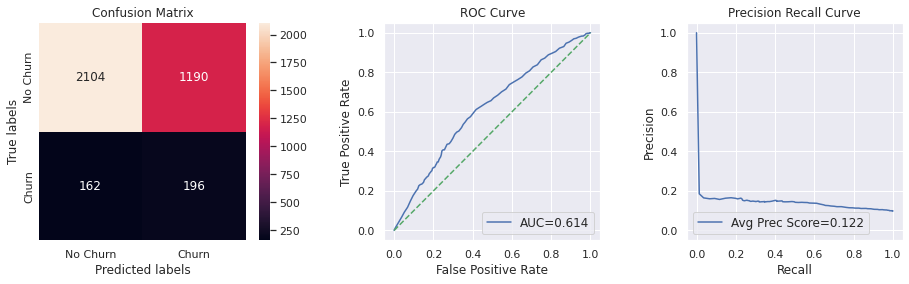

In [ ]:
# Retrain RFB 
rfb4 = RandomForestClassifier(class_weight=weight, random_state=ranstate)
rfb4.fit(X_train_nmus,y_train_nmus)
y_predRFB = rfb4.predict(X_test)
y_probaRFB = rfb4.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predRFB, y_probaRFB[:,1], labels=['No Churn', 'Churn'])

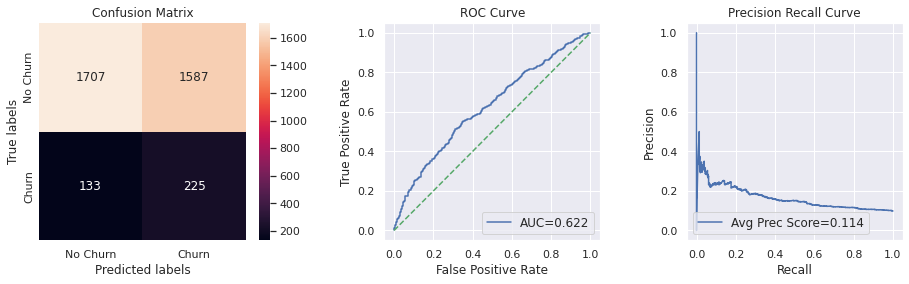

In [ ]:
# Retrain XGB
xgb4 = XGBClassifier(random_state=ranstate)
xgb4.fit(X_train_nmus,y_train_nmus)
y_predXGB = xgb4.predict(X_test)
y_probaXGB = xgb4.predict_proba(X_test)

# generate classification metrics
plot_clf_metrics(y_test, y_predXGB, y_probaXGB[:,1], labels=['No Churn', 'Churn'])

# 7. References:
1. https://theforage.com
2. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
3. https://imbalanced-learn.org/dev/references/generated/imblearn.under_sampling.NearMiss.html
4. https://www.youtube.com/watch?v=kZNkaNATmd8